In [1]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy

# Simulation Modeling

## Using Discrete Event Simulation to help plan Purchase Requisition for Project Coordinators

Send application --> application Review --> Create PR on Requisition Management System --> if Amazon, Place order on amazon with Req. # --> Level 1 approval --> Level 2 approval --> issue PO to merchants --> items delivered --> PR closed

Model components:
* The entities are applications
* Entities are created by email
* Resources at different stages - Employees, Project Coordinators, Level aprrovers - Directors, level 2 approvers - Finance, Indirect Buyer, Merchants, Delivery service
* Entities flow through the different stages of the process, and at each stage; they...... (rewrite)

Our model should handle:
* Uncertainty in the processing times of the individual steps above
* Uncertainty in the application arrival times
* Finite number of different types of resources
* Estimating key process metrics such as wait times, total time in for completion, resource utilisation

The advantages of model .......


**Tools** - DES Software - Simpy


## Model 1: Generate PR applications

Model 1 generates PR Applications. It generates a new Application every n minutes

In [ ]:
def PR_application(env, interapplication_time=5.0):
    """Generate Applications according to a fixed time arrival process"""
    
    # Counter to keep track of number of Applications generated and to serve as a unique Application ID
    application = 0
    
    # Infinite loop for generating Applications
    while True:
        
        # Generate next interapplication time
        iat = interapplication_time
        
        # yield 'timeout' event
        yield env.timeout(iat)
        
        # generate new application
        application += 1
        
        print(f"Application {application} created at time {env.now}")
        

In [ ]:
# Initialize a simulation environment
env1 = simpy.Environment()

# Create and start process generator, and add it to the env (for 1 workday - [60x8] mins )
runtime = 60 * 8
interapplication_time = 10.0
env1.process(PR_application(env1, interapplication_time))

# Run the simulation
env1.run(until=runtime)

### Poisson Arrival Process

In [ ]:
from numpy.random import default_rng
rg = default_rng(seed=4470)

In [ ]:
from scipy.stats import expon
mean_interapplication_time = interapplication_time 

In [ ]:
def Purchase_application_random_1(env, mean_interapplication_time=5.0, rg=default_rng(0)):
    """Generate applications according to a Poisson arrival process"""
    
    # Counter to keep track of number of applications generated and to serve as a unique application ID
    application = 0
    
    # Infinite loop for generating applications
    while True:
        
        # Generate next interapplication time
        iat = rg.exponential(mean_interapplication_time)
        
        # yield 'timeout' event
        yield env.timeout(iat)
        
        # generate new application
        application += 1
        
        print(f"application {application} created at time {env.now}")
        

In [ ]:
# Initialize a simulation environment
env2 = simpy.Environment()

# Create and start process generator, and add it to the env (for 1 workday - [60x8] mins )
runtime = 60 * 8
interapplication_time = 5.0
env2.process(Purchase_application_random_1(env2, interapplication_time))

# Run the simulation
env2.run(until=runtime)

## Model 2: Simplified version with delay process and one resource

* Add a Coordinator resource
* Create a new process function with new delay and resourse
* Modify application process to create PR creation for each PR application

In [ ]:
rg.integers(1,high=301)

In [ ]:
def Purchase_application_Simplified(env, employee, mean_precreation_time, mean_creation_time, mean_postcreation_time, coordinator):
    """Process function modeling how a PR flows through system."""
    print(f"{employee} applied for PR at {env.now:.4f}")
    
    # Yield for the precreation time
    yield env.timeout(rg.exponential(mean_precreation_time))
    
    # Request project coordinator to create PR
    with coordinator.request() as request:
        print(f"{employee} requested coordinator at {env.now:.4f}")
        yield request
        print(f"{employee} received PR at {env.now:.4f}")
        yield env.timeout(rg.normal(mean_creation_time, 0.5))
        
    # Yield for the postcreation time
    yield env.timeout(mean_postcreation_time)
    
    # Process over
    print(f"{employee} received P.O. at {env.now:.4f}")

**Combining process and arrival**

In [ ]:
def Purchase_application_random_2(env, mean_interapplication_time, mean_precreation_time, mean_creation_time,
                              mean_postcreation_time, coordinator,  rg=default_rng(0)):
    """Generate applications according to a Poisson arrival process"""
    
    # Counter to keep track of number of applications generated and to serve as a unique application ID
    application = 0
    
    # Infinite loop for generating applications
    while True:
        
        # Generate next interarrival time
        iat = rg.exponential(mean_interapplication_time)
        
        # yield 'timeout' event
        yield env.timeout(iat)
        
        # generate new application
        application += 1
        
        print(f"application {application} created at time {env.now}")
        
        # Register the process with the simulation environment
        env.process(Purchase_application_Simplified(env, 'Employee{}'.format(application), mean_precreation_time,
                                                    mean_creation_time, mean_postcreation_time, coordinator))
        
        
        

In [ ]:
# Initialize a simulation environment
env3 = simpy.Environment()

# Set input values
mean_interapplication_time = 3.0
mean_precreation_time = 5.0
mean_creation_time = 30
mean_postcreation_time = 120
num_coordinators = 4

# Create Coordinator resource
coordinator = simpy.Resource(env3, num_coordinators)

# register new application process
env3.process(Purchase_application_random_2(env3, mean_interapplication_time, mean_precreation_time, mean_creation_time,
                                           mean_postcreation_time, coordinator))

# Run the simulation
runtime = 50
env3.run(until=runtime)

## Model 3: The PR application model - Version 0.01

* the SimPy environment
* resource capacity related inputs
* data structures to store data collected as PRs flow through the system
* the SimPy resources for modeling the various types of staff modeled
* process methods corresponding to processing times in each stage in the PR flow diagram

In [73]:
class purchase_requisition(object):
    def __init__(self, env, num_coordinators, num_approvers, num_indirectbuyers, rg):
        # Simulation environment
        self.env = env
        self.rg = rg
        
        # list to hold timestamps dictionaries (one per PR)
        self.timestamps_list = []
        # list to hold PR queues (time, queue)
        self.pr_queue = [(0.0, 0.0)]
        self.postapproval_queue = [(0.0, 0.0)]
        
        # Create resources
        self.coordinator = simpy.Resource(env, num_coordinators)
        self.approver = simpy.Resource(env, num_approvers)
        self.indirectbuyer = simpy.Resource(env, num_indirectbuyers)
        
    # Process methods
    def create_PR(self, application):
        yield self.env.timeout(self.rg.exponential(15.0))
        
    def approve(self, application):
        yield self.env.timeout(self.rg.normal(5.0, 1.0))
        
    def create_order(self, application):
        yield self.env.timeout(self.rg.normal(10.0, 3.0))
        
    def create_po(self, application):
        yield self.env.timeout(self.rg.normal(5.0, 1.0))
        

**The create_pr function**

* the simulation environment
* the PR I.D
* the PR object (created from the PRapplication class)
* the random number generator

In [74]:
def createPR(env, application, purchase_requisition, pct_amazon, rg):
    # An application is received
    app_request_ts = env.now
    
    # release coordinator to create PR
    with purchase_requisition.coordinator.request() as request:
        yield request
        # With coordinator, create application
        got_coordinator_ts = env.now
        
        # increase and updated PR queue
        purchase_requisition.pr_queue.append((env.now, purchase_requisition.pr_queue[-1][1] + 1))
        
        yield env.process(purchase_requisition.create_PR(application))
        release_coordinator_ts = env.now
        
    # Request approver to approve PR
    with purchase_requisition.approver.request() as request:
        yield request
        got_approver_ts = env.now
        yield env.process(purchase_requisition.approve(application))
        release_approver_ts = env.now
        
        # decrease and update PR queue
        purchase_requisition.pr_queue.append((env.now, purchase_requisition.pr_queue[-1][1] - 1))
        
        # increase and update post approval queue
        purchase_requisition.postapproval_queue.append((env.now, purchase_requisition.postapproval_queue[-1][1] + 1))
        
    # if amazon order, request coordinator to place order on amazon
    if rg.random() < pct_amazon:
        with purchase_requisition.coordinator.request() as request:
            yield request
            got_coordinator2_ts = env.now
            yield env.process(purchase_requisition.create_order(application))
            release_coordinator2_ts = env.now      
    else:
        got_coordinator2_ts = pd.NA
        release_coordinator2_ts = pd.NA
    
    # Request indirect buyer to issue PO
    with purchase_requisition.indirectbuyer.request() as request:
        yield request
        got_indirectbuyer_ts = env.now
        yield env.process(purchase_requisition.create_po(application))
        release_indirectbuyer_ts = env.now
        
        # decrease and update post approval queue
        purchase_requisition.postapproval_queue.append((env.now, purchase_requisition.postapproval_queue[-1][1] -1))
        
        
    exit_system_ts = env.now
    print(f'PO has been issued for purchase requisition application {application}')
    
    # Create dictionary of timestamps
    timestamps = {'application_id': application,
                  'app_request_ts': app_request_ts,
                  'got_coordinator_ts': got_coordinator_ts,
                  'release_coordinator_ts': release_coordinator_ts,
                  'got_approver_ts': got_approver_ts,
                  'release_approver_ts': release_approver_ts,
                  'got_coordinator2_ts': got_coordinator2_ts,
                  'release_coordinator2_ts': release_coordinator2_ts,
                  'got_indirectbuyer_ts': got_indirectbuyer_ts,
                  'release_indirectbuyer_ts': release_indirectbuyer_ts,
                  'exit_system_ts': exit_system_ts}
    
    purchase_requisition.timestamps_list.append(timestamps)
                  

**The run_pr function**

Function input
* the simulation environment
* the purchase requisition object
* the mean interapplication time
* the percentage of requisitions containing items from amazon
* the random number generator
* stopping condition for the simulation

In [75]:
def run_pr(env, purchase_requisition, mean_interapplication_time, pct_amazon, rg,
           stoptime=simpy.core.Infinity, max_applications=simpy.core.Infinity):
    
    # application counter/ID
    application = 0
    
    # Loop for generating applications
    while env.now < stoptime and application < max_applications:
        
        iat = rg.exponential(mean_interapplication_time)
        yield env.timeout(iat)
        application += 1
        
        print(f"Purchase Requisition application {application} created at time {env.now}")
        
        env.process(createPR(env, application, purchase_requisition, pct_amazon, rg))
        

In [76]:
def main():
    # input parameters
    applications_per_hour = 20
    mean_interapplication_time = 1.0 / (applications_per_hour / 60.0)
    pct_amazon = 0.15
    
    # Random number generator seed
    rg = default_rng(seed=4470)
    
    # Resource capacity levels
    num_coordinators = 7
    num_approvers = 2
    num_indirectbuyers = 2
    
    # Hours of operation
    stoptime = 8*60
    
    # Create simulation environment
    env = simpy.Environment()
    
    # create purchase requisition to simulate
    requisition = purchase_requisition(env, num_coordinators, num_approvers, num_indirectbuyers, rg)
    
    # Register PR creation function
    env.process(run_pr(env, requisition, mean_interapplication_time, pct_amazon, rg, stoptime=stoptime))
    # Run simulation
    env.run()
    
    # Output log files
    pr_application_log_df = pd.DataFrame(requisition.timestamps_list)
    pr_application_log_df.to_csv('./output/pr_application_log_df.csv', index=False)
    
    pr_queue_df = pd.DataFrame(requisition.pr_queue, columns=['ts', 'queue'])
    pr_queue_df.to_csv('./output/pr_queue_df.csv', index=False)
    
    postapproval_queue_df = pd.DataFrame(requisition.postapproval_queue, columns=['ts', 'queue'])
    postapproval_queue_df.to_csv('./output/postapproval_queue_df.csv', index=False)
    
    # Simulation end time
    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return (end_time)
    

In [77]:
pr_end_time = main()

Purchase Requisition application 1 created at time 2.332475473171058
Purchase Requisition application 2 created at time 2.5953536130475916
Purchase Requisition application 3 created at time 3.6925802144818
Purchase Requisition application 4 created at time 6.45939734998565
Purchase Requisition application 5 created at time 8.573989535332474
Purchase Requisition application 6 created at time 9.078268956998846
Purchase Requisition application 7 created at time 14.707528106717373
Purchase Requisition application 8 created at time 19.533846271795827
PO has been issued for purchase requisition application 6
Purchase Requisition application 9 created at time 23.777361701001954
Purchase Requisition application 10 created at time 23.85008402162958
PO has been issued for purchase requisition application 7
PO has been issued for purchase requisition application 2
Purchase Requisition application 11 created at time 29.962935969700226
PO has been issued for purchase requisition application 1
Purch

## Post-processing


In [78]:
pr_application_log_df = pd.read_csv('./output/pr_application_log_df.csv')
pr_application_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   application_id            161 non-null    int64  
 1   app_request_ts            161 non-null    float64
 2   got_coordinator_ts        161 non-null    float64
 3   release_coordinator_ts    161 non-null    float64
 4   got_approver_ts           161 non-null    float64
 5   release_approver_ts       161 non-null    float64
 6   got_coordinator2_ts       22 non-null     float64
 7   release_coordinator2_ts   22 non-null     float64
 8   got_indirectbuyer_ts      161 non-null    float64
 9   release_indirectbuyer_ts  161 non-null    float64
 10  exit_system_ts            161 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 14.0 KB


In [79]:
pr_application_log_df.head()

,application_id,app_request_ts,got_coordinator_ts,release_coordinator_ts,got_approver_ts,release_approver_ts,got_coordinator2_ts,release_coordinator2_ts,got_indirectbuyer_ts,release_indirectbuyer_ts,exit_system_ts
0,6,9.078269,9.078269,10.465810,10.465810,14.934542,NaN,NaN,14.934542,22.201006,22.201006
1,7,14.707528,14.707528,17.002133,17.002133,20.150655,NaN,NaN,20.150655,23.958605,23.958605
2,2,2.595354,2.595354,17.255910,17.255910,23.150843,NaN,NaN,23.150843,29.731249,29.731249
3,1,2.332475,2.332475,19.757187,20.150655,25.421086,NaN,NaN,25.421086,30.554284,30.554284
4,5,8.573990,8.573990,9.178599,9.178599,13.945390,13.94539,28.169596,29.731249,34.328858,34.328858


In [80]:
def compute_durations(timestamp_df):
    
    timestamp_df['wait_for_coordinator'] = timestamp_df.loc[:, 'got_coordinator_ts'] - timestamp_df.loc[:, 'app_request_ts']
    timestamp_df['time_to_create_PR'] = timestamp_df.loc[:, 'release_coordinator_ts'] - timestamp_df.loc[:, 'got_coordinator_ts']
    timestamp_df['wait_for_approver'] = timestamp_df.loc[:, 'got_approver_ts'] - timestamp_df.loc[:, 'release_coordinator_ts']
    timestamp_df['time_to_approve'] = timestamp_df.loc[:, 'release_approver_ts'] - timestamp_df.loc[:, 'got_approver_ts']
    timestamp_df['wait_for_indirectbuyer'] = timestamp_df.loc[:, 'got_indirectbuyer_ts'] - timestamp_df.loc[:, 'release_approver_ts']
    timestamp_df['time_to_issue_po'] = timestamp_df.loc[:, 'release_indirectbuyer_ts'] - timestamp_df.loc[:, 'got_indirectbuyer_ts']
    timestamp_df['post_approval_time'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'release_approver_ts']
    timestamp_df['time_in_system'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'app_request_ts']
    
    return timestamp_df
    
    
    

In [81]:
pr_application_log_df = compute_durations(pr_application_log_df)
pr_application_log_df

,application_id,app_request_ts,got_coordinator_ts,release_coordinator_ts,got_approver_ts,release_approver_ts,got_coordinator2_ts,release_coordinator2_ts,got_indirectbuyer_ts,release_indirectbuyer_ts,exit_system_ts,wait_for_coordinator,time_to_create_PR,wait_for_approver,time_to_approve,wait_for_indirectbuyer,time_to_issue_po,post_approval_time,time_in_system
0,6,9.078269,9.078269,10.465810,10.465810,14.934542,NaN,NaN,14.934542,22.201006,22.201006,0.000000,1.387541,0.000000,4.468732,0.000000,7.266464,7.266464,13.122737
1,7,14.707528,14.707528,17.002133,17.002133,20.150655,NaN,NaN,20.150655,23.958605,23.958605,0.000000,2.294605,0.000000,3.148521,0.000000,3.807950,3.807950,9.251077
2,2,2.595354,2.595354,17.255910,17.255910,23.150843,NaN,NaN,23.150843,29.731249,29.731249,0.000000,14.660556,0.000000,5.894933,0.000000,6.580406,6.580406,27.135895
3,1,2.332475,2.332475,19.757187,20.150655,25.421086,NaN,NaN,25.421086,30.554284,30.554284,0.000000,17.424712,0.393467,5.270431,0.000000,5.133198,5.133198,28.221808
4,5,8.573990,8.573990,9.178599,9.178599,13.945390,13.945390,28.169596,29.731249,34.328858,34.328858,0.000000,0.604610,0.000000,4.766791,15.785858,4.597609,20.383467,25.754868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,147,449.664605,449.664605,496.220231,498.939941,502.675898,502.675898,515.391077,515.391077,518.745072,518.745072,0.000000,46.555626,2.719710,3.735957,12.715179,3.353995,16.069174,69.080466
157,158,471.277789,472.096450,498.382253,501.703216,506.073389,506.073389,516.928779,516.928779,521.163317,521.163317,0.818660,26.285803,3.320963,4.370173,10.855391,4.234537,15.089928,49.885527
158,157,470.462035,471.921490,512.859294,512.859294,517.694162,NaN,NaN,518.745072,522.446227,522.446227,1.459455,40.937804,0.000000,4.834868,1.050910,3.701155,4.752065,51.984192
159,155,467.513463,467.513463,514.040966,514.040966,519.258865,NaN,NaN,521.163317,526.480479,526.480479,0.000000,46.527503,0.000000,5.217899,1.904451,5.317163,7.221614,58.967016


## Histogram of total time in system


(array([25., 52., 36., 22., 13.,  6.,  3.,  2.,  0.,  2.]),
 array([  9.25107675,  19.74400222,  30.23692769,  40.72985316,
         51.22277863,  61.7157041 ,  72.20862957,  82.70155504,
         93.19448051, 103.68740598, 114.18033145]),
 <BarContainer object of 10 artists>)

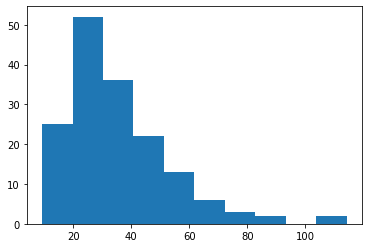

In [82]:
plt.hist(pr_application_log_df['time_in_system'])

In [83]:
pr_application_log_df.loc[:,['wait_for_coordinator', 'wait_for_approver',
                             'wait_for_indirectbuyer', 'time_in_system']].describe()

,wait_for_coordinator,wait_for_approver,wait_for_indirectbuyer,time_in_system
count,161.000000,161.000000,161.000000,161.000000
mean,1.513061,3.556641,4.209364,35.369375
std,3.289892,3.750499,5.222797,18.176976
min,0.000000,0.000000,0.000000,9.251077
25%,0.000000,0.000000,0.000000,22.078621
50%,0.000000,2.719710,3.151163,31.006141
75%,1.459455,5.854277,6.091752,43.302257
max,21.631209,16.645054,29.718476,114.180331


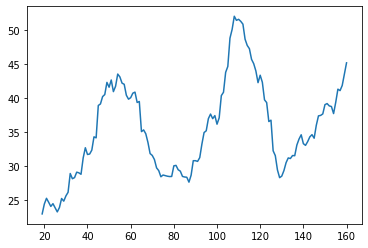

In [84]:
# rolling mean for time in system
y = pr_application_log_df['time_in_system'].rolling(20, 20).mean()
plt.plot(y)

**Resource utilization**


In [85]:
num_coordinators = 7
num_approvers = 2
num_indirectbuyers = 2

In [86]:
available_capacity_coordinator = pr_end_time * num_coordinators
available_capacity_approvers = pr_end_time * num_approvers
available_capacity_indirectbuyers = pr_end_time * num_indirectbuyers

used_capacity_coordinators = pr_application_log_df['time_to_create_PR'].sum()
used_capacity_approvers = pr_application_log_df['time_to_approve'].sum()
used_capacity_indirectbuyers = pr_application_log_df['time_to_issue_po'].sum()

coordinators_utilization = used_capacity_coordinators / available_capacity_coordinator
approvers_utilization = used_capacity_approvers / available_capacity_approvers
indirectbuyers_utilization = used_capacity_indirectbuyers / available_capacity_indirectbuyers

print(coordinators_utilization)
print(approvers_utilization)
print(indirectbuyers_utilization)



0.6785756605540043
0.7796889481301664
0.7725163172109037
